# Višestruka regresija za analizu i predikciju simptoma PCOS-a 


Importujemo glavne biblioteke koje koristimo u projektu

In [2]:
import warnings
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from helper import *

### Učitavanje prikupljenih podataka i njihov prikaz

Učitavamo podatke iz Kaggle seta podataka.  Podaci uključuju medicinske parametre (BMI, insulin, hormoni, simptomi) i 
sadrže informacije o ženama sa PCOS-om. 

In [3]:
df = pd.read_excel("data/data.xlsx", sheet_name="Full_new")
print(df.head())

   Sl. No  Patient File No.  PCOS(Y/N)  Age(yrs)  Weight(kg)  Height(cm)  \
0       1                 1          0      28.0        44.6       152.0   
1       2                 2          0      36.0        65.0       161.5   
2       3                 3          1      33.0        68.8       165.0   
3       4                 4          0      37.0        65.0       148.0   
4       5                 5          0      25.0        52.0       161.0   

         BMI  Blood Group  Pulse rate(bpm)  RR (breaths/min)  ...  \
0  19.304017           15             78.0                22  ...   
1  24.921163           15             74.0                20  ...   
2  25.270891           11             72.0                18  ...   
3  29.674945           13             72.0                20  ...   
4  20.060954           11             72.0                18  ...   

   Pimples(Y/N)  Fast food(Y/N)  Reg.Exercise(Y/N)  BP _Systolic(mmHg)  \
0             0             1.0                  0    

# Analiza prikupljenih podataka

Analizirali smo različite simptome i navike vezane za PCOS pomoću podataka iz nekoliko kolona. Svaka kolona sadrži odgovore u formi "Yes" (Y) ili "No" (N), što nam pomaže da pratimo prisutnost ili odsutnost određenih simptoma ili ponašanja.

Kroz bar grafikon, prikazali smo učestalost odgovora za svaku kategoriju, kao što su: da li osoba ima PCOS, da li je trudna, da li je došlo do povećanja telesne težine, da li se javljaju problemi poput rasta dlaka ili akni, kao i navike poput konzumiranja brze hrane ili redovnog vežbanja.

Na osnovu ovih grafika možemo bolje razumeti koji simptomi su najčešći među osobama sa PCOS-om, kao i kakve životne navike imaju. Ovo nam daje uvid u to koje stvari su najviše povezane sa stanjem zdravlja ispitanika.

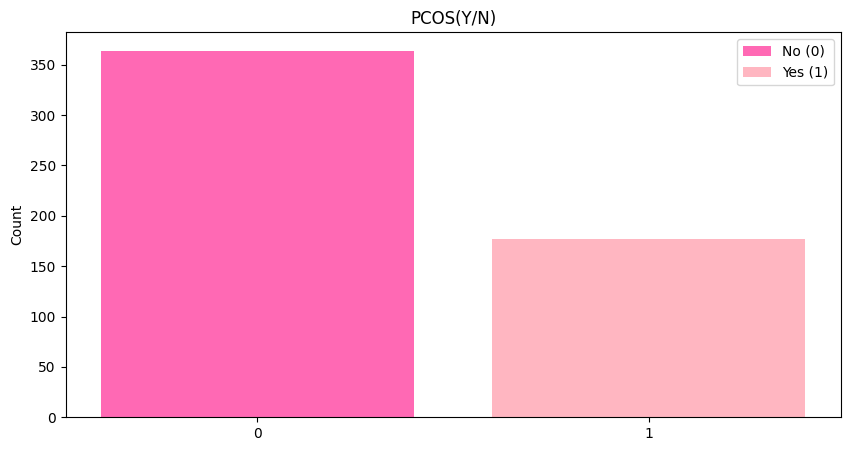

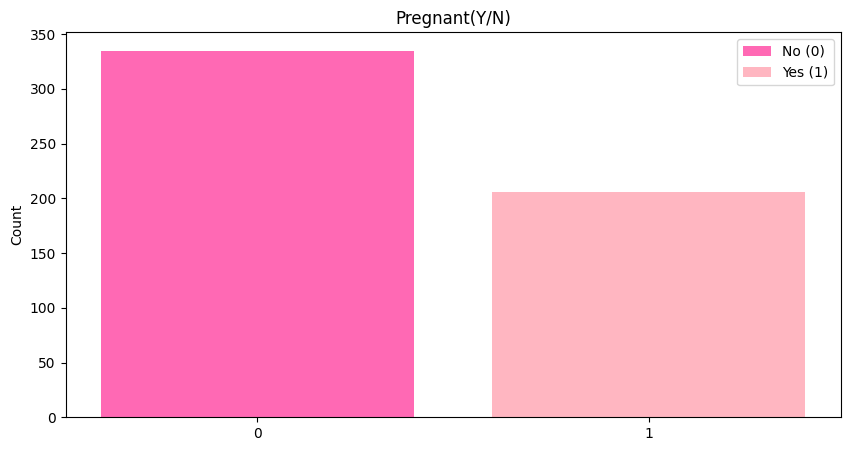

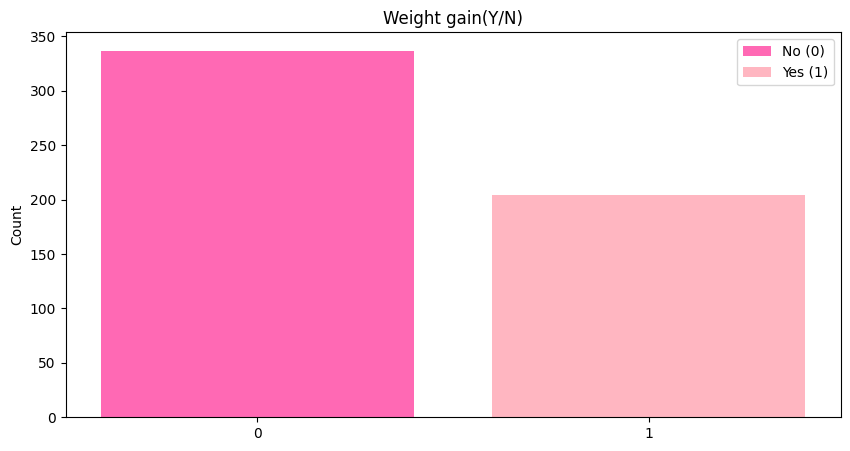

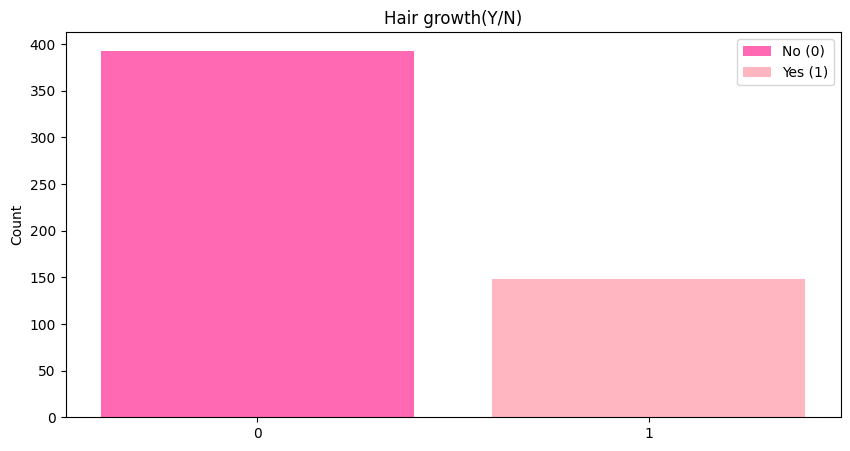

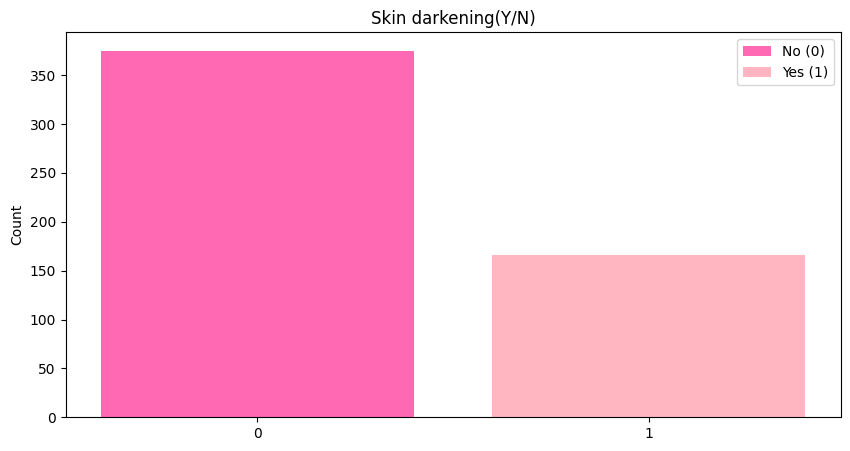

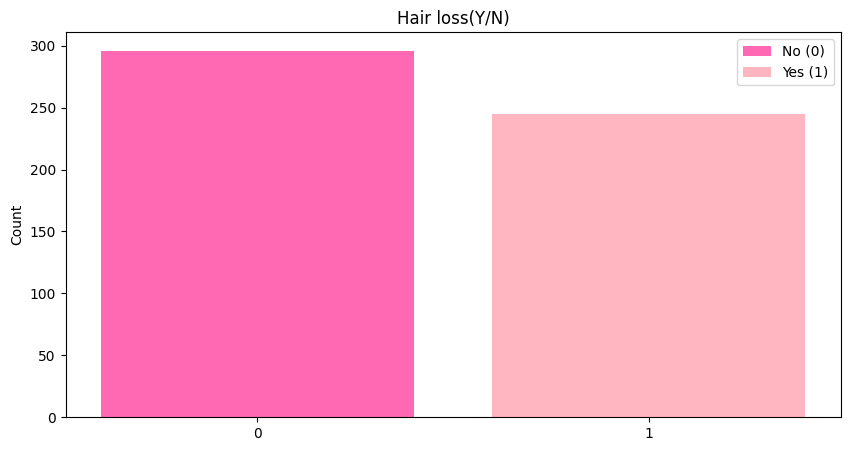

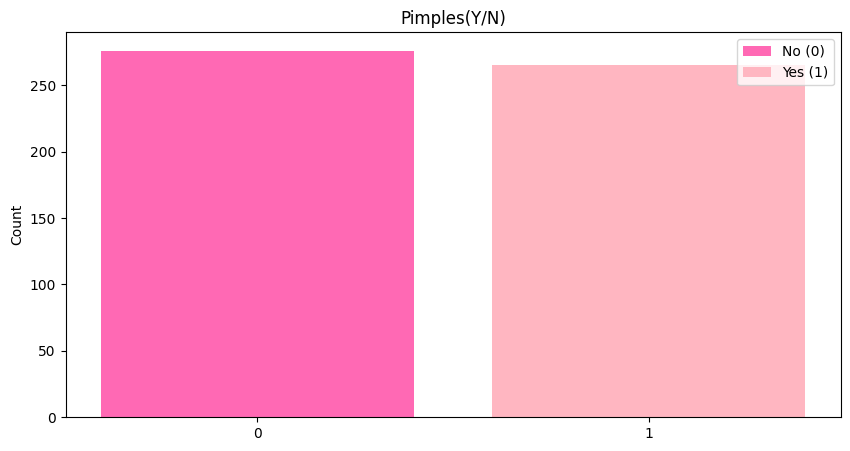

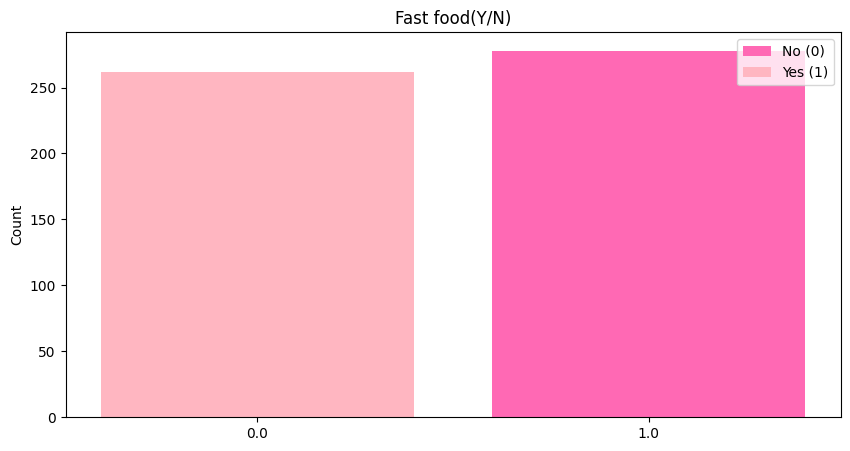

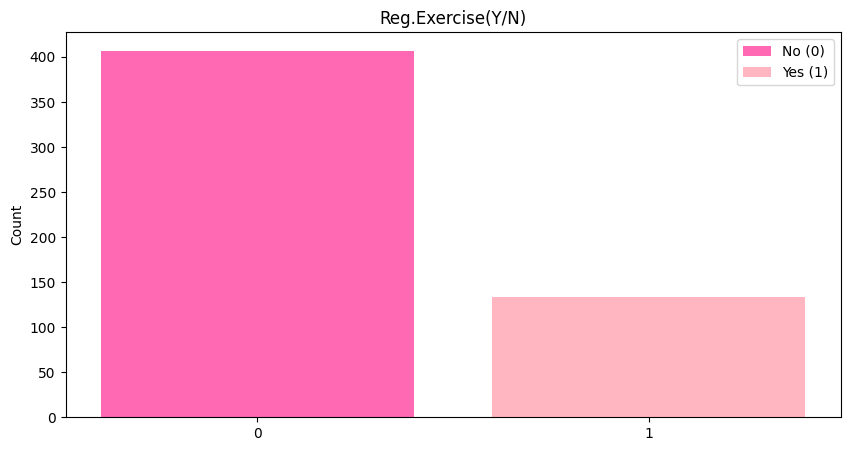

In [3]:
columns = ["PCOS(Y/N)", "Pregnant(Y/N)", "Weight gain(Y/N)", "Hair growth(Y/N)", "Skin darkening(Y/N)", "Hair loss(Y/N)", 
                "Pimples(Y/N)", "Fast food(Y/N)", "Reg.Exercise(Y/N)"]
    
for column in columns:
    bar_plot(df,column)


Analizirali smo i numeričke podatke kao što su starost, težina, visina, dužina ciklusa i krvna grupa pomoću histograma. Svaka od ovih kategorija je vizualizovana kako bi se prikazala raspodela podataka. Takođe, analizirali smo BMI kategorije, grupišući podatke u četiri kategorije: nedovoljna težina, zdrava težina, prekomerna težina i gojaznost. 

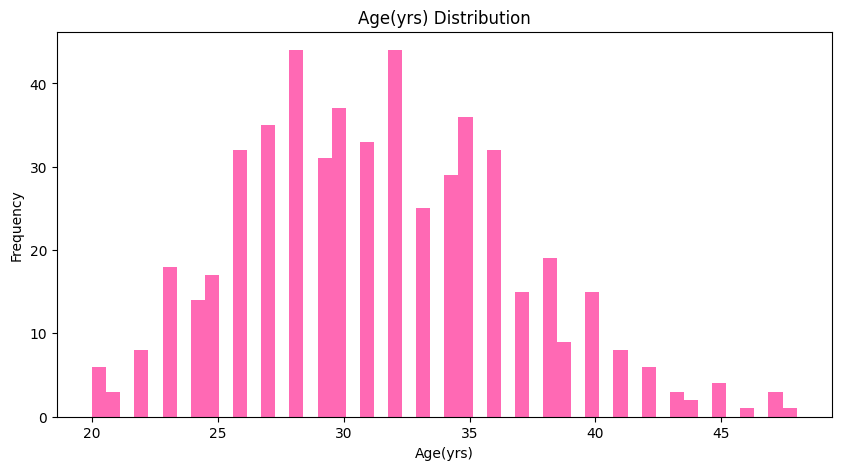

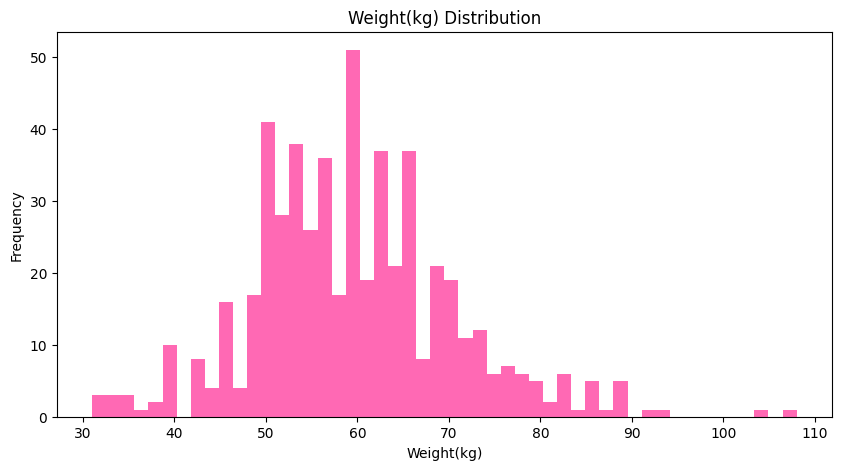

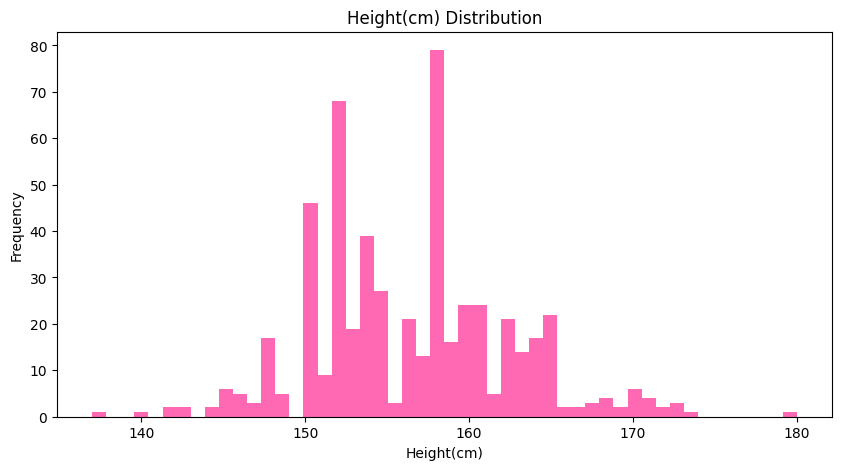

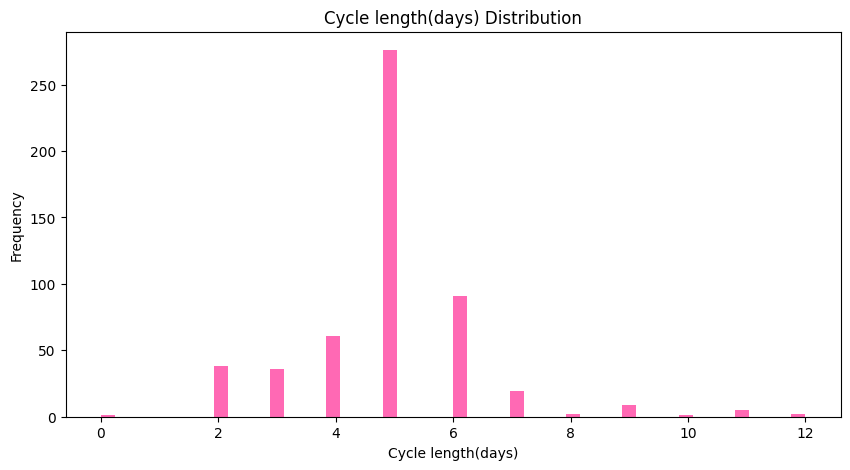

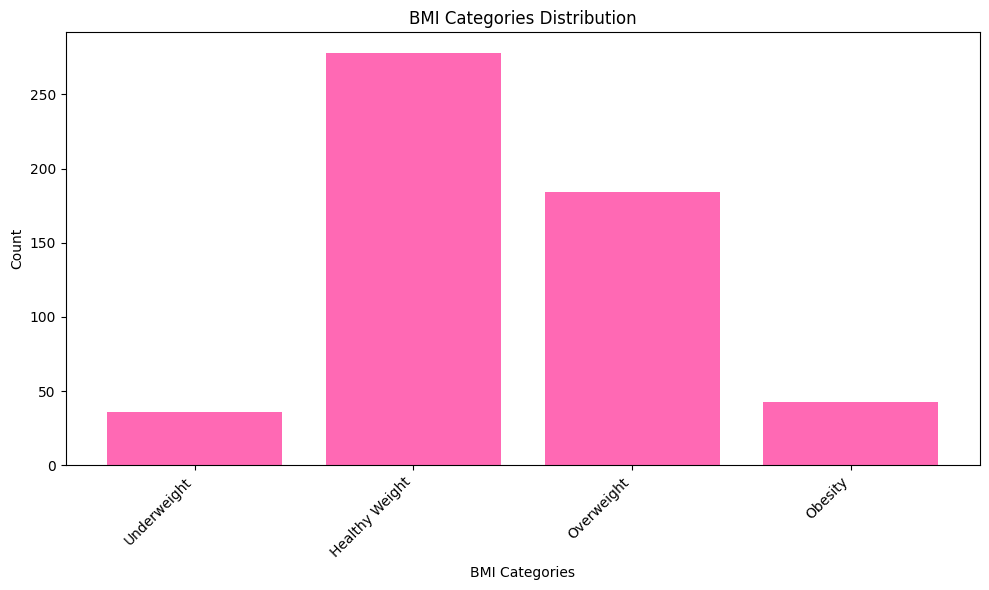

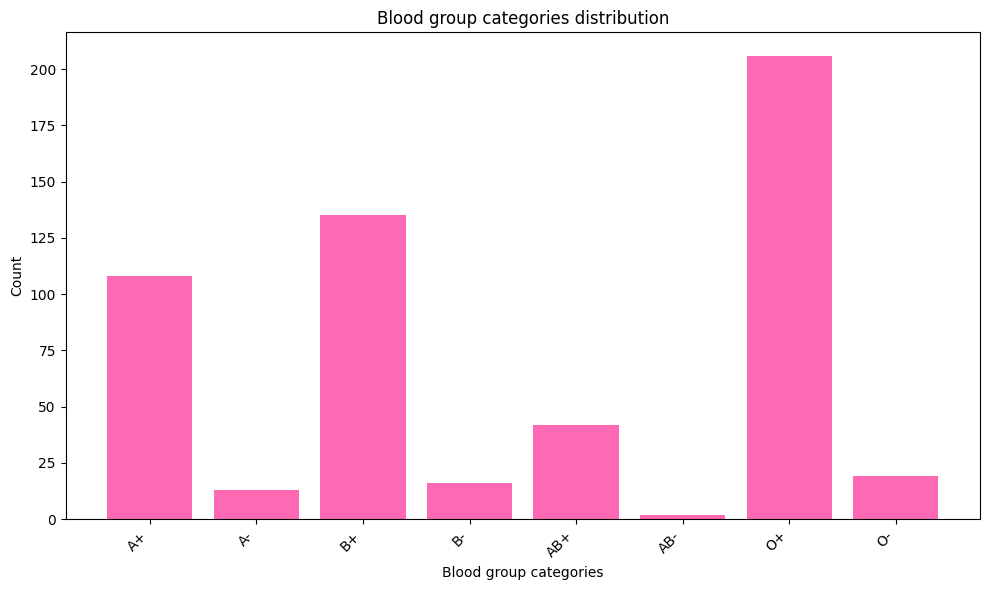

In [4]:
columns = ["Age(yrs)", "Weight(kg)", "Height(cm)", "Cycle length(days)"]
for column in columns:
    plot_histogram(df,column)

bmi_histogram(df)
blood_group_histogram(df)

# Pretprocesiranje podataka

## Obrada nedostajućih vrednosti 

Proveravamo da li imamo nedostajuće vrednosti u našem setu podataka. Ako postoji onda vršimo obradu tih nedostajućih vrednosti korišćenjem metoda kao što su
popunjavanje srednjom vrednošću ili različiti tipovi interpolacije.

In [5]:
print(check_for_missing_values(df))

                      N missing  % missing
Age(yrs)                     11   2.033272
Pulse rate(bpm)              12   2.218115
Marraige Status(Yrs)          1   0.184843
AMH(ng/mL)                   21   3.881701
Vit D3(ng/mL)                37   6.839187
Fast food(Y/N)                1   0.184843


Po rezultatima vidimo da postoje nedostajuće vrednosti u kolonama za Age (yrs), Pulse rate(bpm), Marraige Status (Yrs), AMH(ng/mL), Vit D3 (ng/mL), Fast food (Y/N). Vršimo popunjavanje nedostajućih vrednosti.

In [4]:
df["Age(yrs)"] = df["Age(yrs)"].interpolate(method="linear", limit_direction="both")
df["Pulse rate(bpm)"] = df["Pulse rate(bpm)"].interpolate(method="spline", order=4, limit_direction="both")
df["Marraige Status(Yrs)"] = df["Marraige Status(Yrs)"].interpolate(method="spline", order=4, limit_direction="both")
df["AMH(ng/mL)"] = df["AMH(ng/mL)"].interpolate(method="spline", order=4, limit_direction="both")
df["Vit D3(ng/mL)"] = df["Vit D3(ng/mL)"].interpolate(method="spline", order=4, limit_direction="both")
df["Fast food(Y/N)"] = df["Fast food(Y/N)"].fillna(df['Fast food(Y/N)'].median())

## Analiza korelacije između faktora 

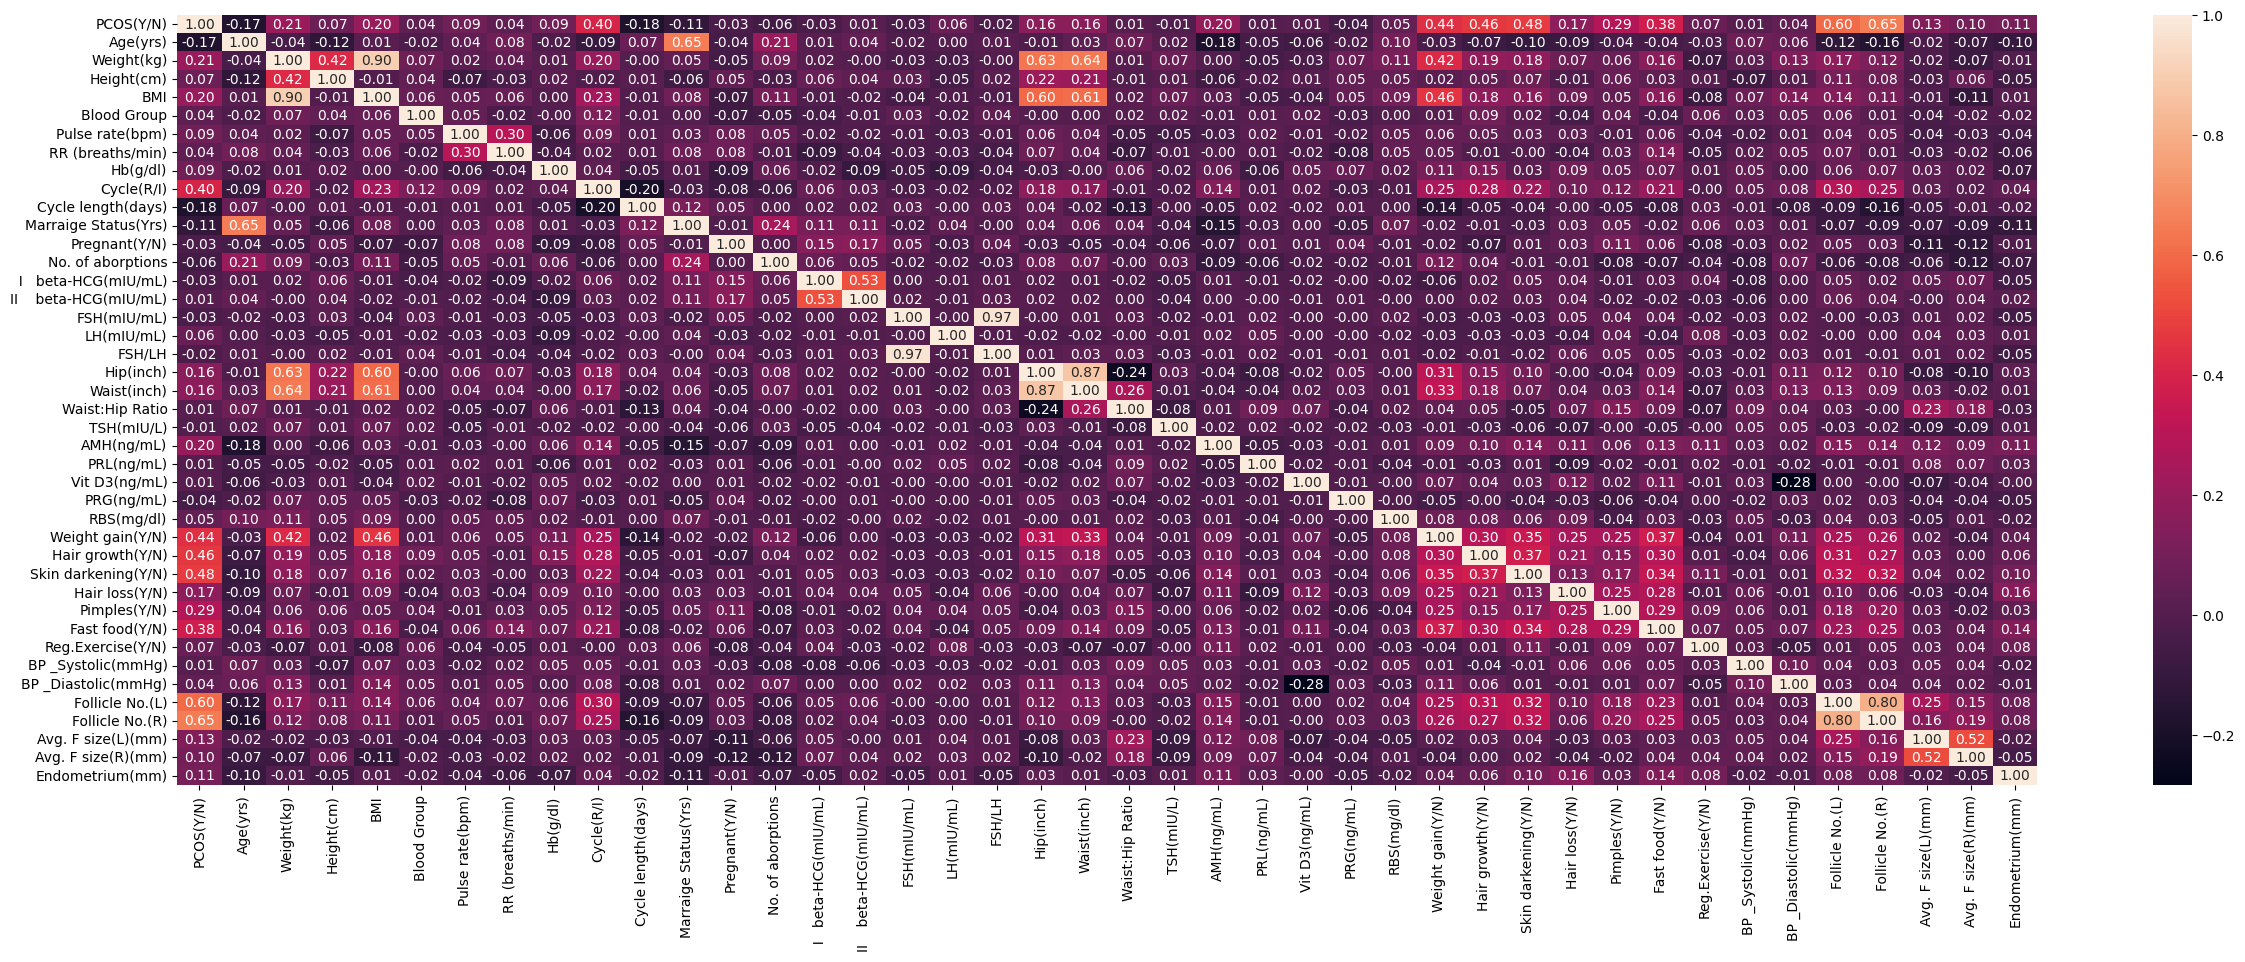

In [7]:
df_copy = df.copy()
df_copy = df_copy.drop(columns=["Sl. No", "Patient File No."])
correlation_matrix(df_copy)

Korelaciona matrica prikazuje odnose između različitih varijabli u datasetu.
Glavni ciljevi analize matrice su:
1. Identifikacija varijabli koje su u visokoj korelaciji.
2. Pronalaženje značajnih odnosa koji mogu ukazivati na uzročno-posledične veze ili faktore rizika PCOS-a.

PCOS pokazuje jake obrasce povezanosti sa fizičkim i hormonskim simptomima što se vidi i u matrici korelacije.

*Korelacija sa PCOS (Y/N) kolonom*:
- Weight gain (Y/N): ~0.44 – Povećanje telesne težine je čest simptom PCOS-a.
- Hair growth (Y/N): ~0.46 – Hirzutizam (prekomerni rast dlaka) je još jedan uobičajen simptom PCOS-a.
- Skin darkening (Y/N): ~0.48 – Ukazuje na povezanost PCOS-a sa hiperpigmentacijom kože (npr. acanthosis nigricans).
- Pimples (Y/N): ~0.29 – Akne su takođe povezane sa hormonskim disbalansima.
- Fast food (Y/N): ~0.38 – Može ukazivati na potencijalne životne navike povezane s PCOS-om.
- Cycle (R/N): ~ 0.40 -  Žene sa nepravilnim ciklusima su češće dijagnostikovane sa PCOS-om.
- Follicle No: ~ 0.60 - Klinički, povećan broj folikula (12 ili više u svakom jajniku) je jedan od ultrazvučnih kriterijuma za dijagnozu PCOS-a

*Ostali odnosi:*
- Visoko korelisana sa Hair growth(Y/N) i Skin darkening(Y/N): ~0.37 – Simptomi se često pojavljuju zajedno.
- Follicle No.(L) i Follicle No.(R) imaju vrlo visoku pozitivnu korelaciju (~0.87). Ovo ima smisla jer se broj folikula u levom i desnom jajniku obično ima slično.
- PRL (ng/mL): Ima slabe korelacije sa većinom varijabli (~0.05 do 0.10), što ukazuje na manju povezanost sa PCOS-om i srodnim simptomima.
- FSH/LH: Povezani su negativno sa PCOS-om i nekim simptomima poput Weight gain (Y/N) (~-0.18). Hormonalni disbalans je glavni faktor kod PCOS-a.

Iz ove matrice zaključujemo da možemo da izbacimo  kolone poput Blood Group, RBS (mg/dl), BP_Systolic (mmHg), i BP_Diastolic (mmHg) jer imaju vrlo nisku korelaciju sa ciljem analize i ostalim varijablama, te ne doprinose značajno modelu.
Takođe, kolone sa visokom međusobnom korelacijom, poput Follicle No. (L) i Follicle No. (R) ili Hair growth(Y/N) i Skin darkening(Y/N) mogu se redukovati zadržavanjem samo jedne za smanjenje redundantnosti.

# Razvoj regresionih modela

In [ ]:
Y = df["PCOS(Y/N)"]
X = df[["Cycle(R/I)", "AMH(ng/mL)", "PRG(ng/mL)", "Fast food(Y/N)", "BMI", "Cycle length(days)",
        "Weight gain(Y/N)", "Hair growth(Y/N)", "Skin darkening(Y/N)", 
        "Pimples(Y/N)", "Follicle No.(L)"]]
 

x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=60)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=60)
    
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)
    
linear_model = get_linear_model(x_train, y_train)
ridge_model = get_ridge_model(x_train_scaled, y_train)
lasso_model = get_lasso_model(x_train_scaled, y_train)
logistic_model = get_logistic_model(x_train, y_train)

Za ovaj projekat smo odabrali karakteristike koje smatramo važnim za analizu PCOS-a, bazirano na prethodnim istraživanjima i korelaciji između varijabli. Odabrane karakteristike su:

- **Cycle (R/I)**: Da li je ciklus regulisan ili neregulisan.
- **AMH (ng/mL)**: Anti-milerov hormon.
- **PRG (ng/mL)**: Progesteron.
- **Fast food (Y/N)**: Konzumacija brze hrane.
- **BMI**: Indeks telesne mase.
- **Cycle length (days)**: Dužina menstrualnog ciklusa.
- **Weight gain (Y/N)**: Da li je došlo do dobitka na težini.
- **Hair growth (Y/N)**: Da li postoji rast dlaka.
- **Skin darkening (Y/N)**: Da li je došlo do potamnjivanja kože.
- **Pimples (Y/N)**: Da li postoje akne.
- **Follicle No. (L)**: Broj folikula na levom jajniku.

Ove karakteristike su izabrane jer se prethodna istraživanja poklapaju sa njihovim značajem u vezi sa PCOS-om.

**Podela podataka:** Podaci su podeljeni u tri grupe:  
- **Trening skup (60%)**: Koristi se za obučavanje modela.  
- **Validacioni skup (20%)**: Koristi se za proveru tačnosti modela tokom obučavanja.  
- **Test skup (20%)**: Koristi se za testiranje konačnog modela.

Podaci su podeljeni koristeći metodu `train_test_split`, sa zadatim nasumičnim semenom (random_state=60) kako bi podela bila ponovljiva.

**Skaliranje podataka:** Da bi podaci bili ujednačeni, primenili smo standardizaciju pomoću `StandardScaler`-a. Ovo je važno za modele poput **Ridge** i **Lasso regresije**, koji su osetljivi na razliku u opsegu podataka. Skaliranje nije bilo potrebno za **Linearnu** i **Logističku regresiju**, jer ovi modeli nisu osetljivi na razlike u opsegu.

**Izbor modela:** Koristili smo nekoliko regresionih modela:
1. **Linearna regresija**: Koristi se kao osnovni model za početnu procenu.
2. **Ridge regresija**: Koristi L2 regularizaciju da bi smanjila varijansu i sprečila prekomerno prilagođavanje.
3. **Lasso regresija**: Koristi L1 regularizaciju, koja može ukloniti nepotrebne karakteristike i učiniti model lakšim za interpretaciju.
4. **Logistička regresija**: Koristi se jer je cilj klasifikacija, odnosno predviđanje prisustva ili odsustva PCOS-a.

Svaki model je izabran sa ciljem da pomogne u boljoj analizi i predviđanju rezultata.

# Evaluacija modela

Za svaki model, pozvali smo funkciju koja prikazuje rezultate evaluacije, odnosno kako se model ponaša na validacionim podacima.

In [9]:
print("Evaluation Results (Validation Set):")
evaluate_model(linear_model, "Linear Regression", x_val, y_val)
evaluate_model(ridge_model, "Ridge Regression", x_val_scaled, y_val)
evaluate_model(lasso_model, "Lasso Regression", x_val_scaled, y_val)
evaluate_model(logistic_model, "Logistic Regression", x_val, y_val)

Evaluation Results (Validation Set):
Linear Regression Model:
SSE: 12.047983745922553
RMSE: 0.3339991093623431
R²: 0.5410291906315219
R² adj : 0.48843878539138375

Ridge Regression Model:
SSE: 12.046490098447482
RMSE: 0.33397840496898124
R²: 0.5410860914877149
R² adj : 0.48850220613734885

Lasso Regression Model:
SSE: 11.95914782124001
RMSE: 0.3327654582384818
R²: 0.5444134163337139
R² adj : 0.4922107869552853

Logistic Regression Model:
SSE: 16
RMSE: 0.3849001794597505
R²: 0.3904761904761904
R² adj : 0.3206349206349205



Linear Regression: Ima SSE od 12.05, što znači da model nije savršeno precizan, ali je u okvire prihvatljive greške. RMSE je 0.334, što je okej, ali ne idealno. R² je 0.541, što znači da model objašnjava 54.1% varijacije u podacima, što je pristojno, ali nije sjajno. Adjusted R² je 0.488, što ukazuje na to da model nije idealan, ali nije ni loš.

Ridge Regression: Ima skoro identičan SSE i RMSE kao Linear Regression, što znači da nije mnogo bolji. R² je vrlo sličan Linear Regression (0.541), a adjusted R² je 0.488, što ponovo pokazuje da model nije značajno bolji od Linear Regression.

Lasso Regression: Ovaj model ima nešto bolji SSE (11.96) i RMSE (0.333), što ga čini preciznijim od prethodna dva modela. R² je 0.544, što je malo bolje od Linear i Ridge Regression, i adjusted R² je 0.492, što ukazuje da je ovaj model malo bolji u objašnjavanju podataka.

Logistic Regression: Ovaj model ima mnogo veći SSE (16) i RMSE (0.385), što znači da je najmanje precizan po ovim metrikama. R² je 0.390, što znači da objašnjava samo 39% varijacije, što je prilično loše za regresiju. Adjusted R² je 0.320, što još više potvrđuje da ovaj model nije dobar u ovom kontekstu. Međutim, treba napomenuti da su metrike kao što su SSE, RMSE i R² neprikladni za Logistic Regression, jer je to klasifikacioni model. Ovi metrike su specifični za regresiju, pa bi za Logistic Regression trebalo koristiti druge metrike.

Takođe, pozvali smo funkciju koja prikazuje rezultate evaluacije, odnosno kako se model ponaša na test podacima.

In [10]:
print("Final Evaluation Results (Test Set):")
evaluate_model(linear_model, "Linear Regression", x_test, y_test)
evaluate_model(ridge_model, "Ridge Regression", x_test_scaled, y_test)
evaluate_model(lasso_model, "Lasso Regression", x_test_scaled, y_test)
evaluate_model(logistic_model, "Logistic Regression", x_test, y_test)

Final Evaluation Results (Test Set):
Linear Regression Model:
SSE: 8.907997682795754
RMSE: 0.2858754088470138
R²: 0.5903072795676215
R² adj : 0.5438472803433312

Ridge Regression Model:
SSE: 8.90697720860855
RMSE: 0.2858590338522483
R²: 0.5903542127686363
R² adj : 0.5438995358661105

Lasso Regression Model:
SSE: 8.87684524258198
RMSE: 0.28537509908828973
R²: 0.5917400289276642
R² adj : 0.5454425064349251

Logistic Regression Model:
SSE: 13
RMSE: 0.34534917843520574
R²: 0.4021097046413503
R² adj : 0.3343077123841839



Linear Regression: SSE  iznosi 8.91, što znači da je zbir grešaka u predikcijama relativno nizak. RMSE je 0.29, što ukazuje da je prosečna greška u predikcijama 0.29. R² (Coefficient of Determination) je 0.59, što znači da model objašnjava 59% varijacije u podacima, što nije loše, ali može biti bolje. R² adjusted je 0.54, što je malo niže, jer uzima u obzir broj varijabli i pokazuje da model ne donosi značajnu promenu u odnosu na jednostavniji model.

Ridge Regression: SSE je vrlo sličan onom za linearnu regresiju i iznosi 8.91. RMSE je takođe 0.29, što znači da su greške u predikcijama vrlo slične onima iz linearnog modela. R² iznosi 0.59, što znači da Ridge regresija ne donosi veliko poboljšanje u objašnjenju podataka u poređenju sa običnom linearnom regresijom. Prilagođeni R² je 0.54, što je takođe veoma slično prethodnoj vrednosti, što ukazuje da Ridge regresija ne donosi značajnu prednost u odnosu na običnu linearnu regresiju.

Lasso Regression: SSE je 8.88, što je blago niže nego za prethodne modele, što znači da su greške u predikcijama nešto manja. RMSE je 0.29, što je skoro isto kao kod drugih modela, ukazujući da je prosečna greška još uvek slična. R² je 0.59, što znači da model objašnjava oko 59% varijacije, kao i ostali modeli, pa se može reći da nije doneta velika promena u objašnjenju podataka. R² adjusted je 0.55, što je malo veće nego kod prethodnih modela, što može značiti da Lasso koristi varijable malo efikasnije, ali je razlika minimalna.

Logistic Regression: SSE je 13, što je znatno veće od prethodnih modela, što znači da su greške u predikcijama veće. RMSE je 0.35, što je takođe veće u odnosu na druge modele, što ukazuje da su greške u predikcijama prosečno veće. R² je 0.40, što znači da model objašnjava samo 40% varijacije u podacima, što je znatno niže u poređenju sa prethodnim modelima. R² adjusted je 0.33, što je još niže, što sugeriše da model nije efikasan u objašnjenju podataka. Međutim, treba napomenuti da ove metrike nisu odgovarajuće za logističku regresiju, jer je to model za klasifikaciju, a ne za regresiju, pa se za evaluaciju ovakvih modela koriste druge metrike poput tačnosti ili AUC.

AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) je merilo koje se koristi za evaluaciju performansi logističkog regresionog modela, jer pokazuje koliko dobro model razlikuje pozitivne od negativnih primera. AUC vrednost se kreće između 0 i 1, pri čemu viša vrednost označava bolju sposobnost modela da pravilno klasifikuje podatke. Ova metrika je korisna jer je nezavisna od praga klasifikacije i daje preciznu sliku o modelu, čak i kada su klase neravnotežno raspodeljene. Zbog toga je AUC-ROC pogodna za ocenu modela u različitim situacijama i idealna za logističke modele.

In [11]:
y_pred_logistic_proba_val = logistic_model.predict_proba(x_val)[:, 1] 
auc_val = roc_auc_score(y_val, y_pred_logistic_proba_val)
print(f"Logistic Regression AUC-ROC on Validation Set: {auc_val:.4f}\n")

Logistic Regression AUC-ROC on Validation Set: 0.9189



AUC-ROC vrednost od 0.9189 za logistički regresioni model na validacionom skupu podataka ukazuje na vrlo dobru sposobnost modela da razlikuje pozitivne od negativnih primera.